In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy import stats
import json 
import matplotlib as mpl
plt.rcParams['figure.dpi'] = 300
from Bio import SeqIO, Seq
from Bio.Seq import Seq
from datetime import datetime as dt
import datetime

Codon_AA =  {"TTT":"F", "TTC":"F", "TTA":"L", "TTG":"L",
             "TCT":"S", "TCC":"S", "TCA":"S", "TCG":"S",
             "TAT":"Y", "TAC":"Y", "TAA": "stop", "TAG": "stop",
             "TGT":"C", "TGC":"C", "TGG":"W", "TGA": "stop",
             "CTT":"L", "CTC":"L", "CTA":"L", "CTG":"L",
             "CCT":"P", "CCC":"P", "CCA":"P", "CCG":"P",
             "CAT":"H", "CAC":"H", "CAA":"Q", "CAG":"Q",
             "CGT":"R", "CGC":"R", "CGA":"R", "CGG":"R",
             "ATT":"I", "ATC":"I", "ATA":"I", "ATG":"M",
             "ACT":"T", "ACC":"T", "ACA":"T", "ACG":"T",
             "AAT":"N", "AAC":"N", "AAA":"K", "AAG":"K",
             "AGT":"S", "AGC":"S", "AGA":"R", "AGG":"R",
             "GTT":"V", "GTC":"V", "GTA":"V", "GTG":"V",
             "GCT":"A", "GCC":"A", "GCA":"A", "GCG":"A",
             "GAT":"D", "GAC":"D", "GAA":"E", "GAG":"E",
             "GGT":"G", "GGC":"G", "GGA":"G", "GGG":"G" }

AminoAcid = list(set(Codon_AA.values()))


def find_site_index(mut):
    """
    return index of sites given a mutation 
    e.g., mut = ins214EPE return [3,4,5]
    """
    idx_list = []
    for i,j in enumerate(mut):
        try:
            int(j)
            idx_list.append(i)
        except: 
            pass
    return(idx_list)


def renumber_index(mut_list, VoC_seq):
    """
    Returns corresponding Wuhan sequence numbering for a given VoC
    """
    wuhan_num = np.arange(len(VoC_seq))
    for mut in mut_list:
        if "del" in mut:
            #print("del")
            site_idx = find_site_index(mut)
            del_site = int(mut[site_idx[0]:site_idx[-1]+1])
            wuhan_num[wuhan_num >= del_site-1] += 1 
       
        elif "ins" in mut:
            #print("insertion")
            site_idx = find_site_index(mut)
            ins_site = int(mut[site_idx[0]:site_idx[-1]+1])
            num_aa_inserted = len(mut[site_idx[-1]+1:])
            for i in range(num_aa_inserted):
                wuhan_num[wuhan_num >= ins_site] -= 1
            
    renum_df  = pd.DataFrame({"wuhan_num": wuhan_num+1, "VoC_num": np.arange(len(wuhan_num))+1})
    return(renum_df)

def renumber_df(VoC):
    if VoC == "WuhanG":
        fasta_path = "../Sequences/wuhan.fasta"
        seq = SeqIO.read(open(fasta_path),'fasta')
        seq = "".join(seq.seq)
        wuhan_num = np.arange(len(seq))
        renum_df = pd.DataFrame({"wuhan_num": wuhan_num+1, "VoC_num": np.arange(len(wuhan_num))+1})
    else:
        fasta_path = "../Sequences/"+VoC+".fasta"
        seq = SeqIO.read(open(fasta_path),'fasta')
        seq = "".join(seq.seq)
        renum_df = renumber_index(VoC, seq)
        renum_df['voc_seq'] = [seq[i-1] for i in renum_df['VoC_num']]
    return(renum_df)

def get_corr_mutation(voc_muts):
    voc_corr = []
    for i in voc_muts:
        if 'del' not in i and 'ins' not in i:
            wt_wu  = i[0]
            pos_wu = int(i[1:-1])

            pos_voc = renum_df[renum_df['wuhan_num'] == pos_wu]['VoC_num'].iloc[0]
            wt_voc  = renum_df[renum_df['wuhan_num'] == pos_wu]['voc_seq'].iloc[0]

            voc_corr.append(wt_voc + str(pos_voc) + wt_wu)
    return(voc_corr)

def find_syn_codons(a, Codon_AA):
    syn_cdns= []
    for c in Codon_AA:
        if Codon_AA[c] == a:
            syn_cdns.append(c)
    return(syn_cdns)

def syn_cdn_dict(AminoAcid, Codon_AA):
    AA_Codon = dict.fromkeys(AminoAcid)
    for a in AminoAcid:
        AA_Codon[a] = find_syn_codons(a, Codon_AA)
    return(AA_Codon)

def nuc_diff(source, target):
    '''
        Returns the number of nucleotide difference(s) between two codons.
    '''
    return sum([1 for i in range(len(source)) if source[i] != target[i]])


def find_min_dist(c1, cdn_b):
    dists = [nuc_diff(c1, c2) for c2 in cdn_b]
    return(min(dists))

AA_Codon = syn_cdn_dict(AminoAcid, Codon_AA)

A = []; B= []; D= []
for a in AA_Codon: 
    for b in AA_Codon:
        c1 = AA_Codon[a]
        c2 = AA_Codon[b]
        min_dists = [find_min_dist(c, c2) for c in c1]
        A.append(a)
        B.append(b)
        D.append(min(min_dists))
nt_dist = pd.DataFrame({"wt": A, "subs": B, "min_nt_dist": D})

In [2]:
count_gisaid = 1000
top_percent  = 0.95

In [3]:
### Get mutations seen > 100x during pandemic ### 
mut_month_count = pd.read_csv('../Data/mutation_count_per_month_2024-02-05.csv')
mut_month_count['Date'] = pd.to_datetime(mut_month_count['Date'], format='%Y-%m')

dates = mut_month_count['Date'].unique()

seen_muts_dict = {}
for month in dates: 
    subset_df = mut_month_count[mut_month_count['Date'] <= month].groupby('Mutation').sum().reset_index()
    seen_muts = subset_df[subset_df['Count'] >= count_gisaid].Mutation.tolist()
    seen_muts_dict[month] = [i[1:] for i in seen_muts]

In [4]:
## Get escape mutations for each model ##
voc_db = pd.read_csv('../Data/Supp_TableS4_Construct_Summary.csv')

model_escape_dict = {}
for model in ['B.1_pre2020', 'B.1', "BA.5", 'BA.2.12.1', 'BA.2.75', 'XBB']:
   
    if model == 'B.1_pre2020':
        voc = "B.1"
    else:
        voc = model
    
    #read in evescape
    evescape = pd.read_csv('../EVEscape/'+model+'_evescape.csv')
    
    #remove reversions
    voc_muts = voc_db[voc_db.Name == voc]["All mutations"].iloc[0].split(",")
    renum_df = renumber_df(voc)
    voc_corr = get_corr_mutation(voc_muts)
    
    # Subset to one nt mutations
    evescape = evescape.merge(nt_dist, on = ['wt', 'subs'], how = 'left')
    evescape = evescape[~evescape.mutant.isin(voc_corr)]
    
    evescape_1nt = evescape[evescape.min_nt_dist == 1].copy()
    
    # Subset to RBD 
    evescape_1nt  = evescape_1nt[(evescape_1nt['wuhan_num'] >= 331) & (evescape_1nt['wuhan_num'] <= 531)].copy()
    
    #calculate percentile 
    evescape_1nt['1nt_rbd_pct'] = evescape_1nt["EVEscape_2xfit"].rank(pct = True)
    evescape_top10 =  evescape_1nt[evescape_1nt['1nt_rbd_pct'] >= top_percent].copy()
    evescape_top10['wuhan_mutant'] = evescape_top10.wuhan_num.astype(str) +evescape_top10.subs
    
    
    # define top escape mutaitons 
    escape_muts = evescape_top10.wuhan_mutant.tolist()
    voc_res = [i[1:] for i in voc_muts]
    
    model_escape_dict[model] = list(set(escape_muts + voc_res))

In [5]:
exp_dms = pd.read_csv('../Data/bloom_rbd_escape_data_20220109.csv')
exp_dms = exp_dms.rename(columns={'site': 'i', 'wildtype': 'wt','mutation': 'subs'})

<ipython-input-5-2de2faec2f26>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exp_dms = pd.read_csv('../Data/bloom_rbd_escape_data_20220109.csv')


In [6]:
bloom = exp_dms[exp_dms.lab == 'Bloom_JD']
greaney_dms = bloom[bloom.study == '2021_Greaney_Crowe_Abs'].copy()
greaney_dms = greaney_dms.groupby(['i', 'wt', 'subs']).mut_escape.agg('max').reset_index()

# Subset to one nt mutations
greaney_dms = greaney_dms.merge(nt_dist, on = ['wt', 'subs'], how = 'left')
greaney_dms_1nt = greaney_dms[greaney_dms.min_nt_dist == 1].copy()

# Subset to RBD 
greaney_dms_1nt  = greaney_dms_1nt[(greaney_dms_1nt['i'] >= 331) & (greaney_dms_1nt['i'] <= 531)].copy()

#calculate percentile 
greaney_dms_1nt['1nt_rbd_pct'] = greaney_dms_1nt["mut_escape"].rank(pct = True)
greaney_dms_top10 =  greaney_dms_1nt[greaney_dms_1nt['1nt_rbd_pct'] >= top_percent].copy()

# define top escape mutaitons 
greaney_dms_top10['wuhan_mutant'] = greaney_dms_top10.i.astype(str) + greaney_dms_top10.subs
escape_muts = greaney_dms_top10.wuhan_mutant.tolist()

model_escape_dict['Greaney_dms'] = escape_muts

In [7]:
bloom = exp_dms[exp_dms.lab == 'Bloom_JD']
bloom_dms = bloom.groupby(['i', 'wt', 'subs']).mut_escape.agg('max').reset_index()

# Subset to one nt mutations
bloom_dms = bloom_dms.merge(nt_dist, on = ['wt', 'subs'], how = 'left')
bloom_dms_1nt = bloom_dms[bloom_dms.min_nt_dist == 1].copy()

# Subset to RBD 
bloom_dms_1nt  = bloom_dms_1nt[(bloom_dms_1nt['i'] >= 331) & (bloom_dms_1nt['i'] <= 531)].copy()

#calculate percentile 
bloom_dms_1nt['1nt_rbd_pct'] = bloom_dms_1nt["mut_escape"].rank(pct = True)
bloom_dms_top10 =  bloom_dms_1nt[bloom_dms_1nt['1nt_rbd_pct'] >= top_percent].copy()

# define top escape mutaitons 
bloom_dms_top10['wuhan_mutant'] = bloom_dms_top10.i.astype(str) + bloom_dms_top10.subs
escape_muts = bloom_dms_top10.wuhan_mutant.tolist()

model_escape_dict['all_dms'] = escape_muts

In [8]:
xie_dms = exp_dms[exp_dms.lab == 'Xie_XS']
xie_dms = xie_dms.groupby(['i', 'wt', 'subs']).mut_escape.agg('max').reset_index()
xie_dms = xie_dms.fillna(0)

# Subset to one nt mutations
xie_dms = xie_dms.merge(nt_dist, on = ['wt', 'subs'], how = 'left')
xie_dms_1nt = xie_dms[xie_dms.min_nt_dist == 1].copy()

# Subset to RBD 
xie_dms_1nt  = xie_dms_1nt[(xie_dms_1nt['i'] >= 331) & (xie_dms_1nt['i'] <= 531)].copy()

#calculate percentile 
xie_dms_1nt['1nt_rbd_pct'] = xie_dms_1nt["mut_escape"].rank(pct = True)
xie_dms_top10 =  xie_dms_1nt[xie_dms_1nt['1nt_rbd_pct'] >= top_percent].copy()

# define top escape mutaitons 
xie_dms_top10['wuhan_mutant'] = xie_dms_top10.i.astype(str) + xie_dms_top10.subs
escape_muts = xie_dms_top10.wuhan_mutant.tolist()

model_escape_dict['xie_dms'] = escape_muts

In [9]:
import random as rdm

eve_model = pd.read_csv('../EVEscape/B.1_pre2020_evescape.csv')
eve_model = eve_model.merge(nt_dist, on = ['wt', 'subs'], how = 'left')
eve_model = eve_model[eve_model.min_nt_dist == 1].copy()

eve_model['wuhan_mut'] = eve_model.pos.astype(str) + eve_model.subs
random = rdm.sample(eve_model['wuhan_mut'].tolist(), k = int(len(eve_model)*(1-top_percent)))
model_escape_dict['spk_random'] = random

rbd_model = eve_model[(eve_model.pos >= 331) & (eve_model.pos <= 531)]
random = rdm.sample(rbd_model['wuhan_mut'].tolist(), k = int(len(rbd_model)*(1-top_percent)))
model_escape_dict['rbd_random'] = random

In [10]:
frac_seen = {}

for model in model_escape_dict:
    escape_muts = model_escape_dict[model]
    
    prop = []
    for month in dates: 
        prop_m = sum([1 for i in escape_muts if i in seen_muts_dict[month]])
        prop.append(prop_m / len(escape_muts))
        #prop.append(prop_m)
    frac_seen[model] = prop

In [13]:
voc_dates = {   "B.1_pre2020": np.datetime64('2020-01-01'),
                "BA.5": np.datetime64('2021-12-01'),
                "BA.2.12.1": np.datetime64('2022-02-01'),
                "BA.2.75": np.datetime64('2022-05-01'),
                "XBB": np.datetime64('2022-07-01')}

rbd_dates = {
             'all_dms'    :np.datetime64('2021-10-12'),
             'Greaney_dms':np.datetime64('2020-09-10'), 
             }

In [14]:
f= []

for i,d in enumerate(dates):
    if d < voc_dates["BA.5"]:
        frac = frac_seen['B.1_pre2020'][i]
        f.append(frac)
    elif d >= voc_dates["BA.5"] and d<= voc_dates["BA.2.12.1"]:
        f.append(frac_seen['BA.5'][i])
    elif d >= voc_dates["BA.2.12.1"] and d<= voc_dates["BA.2.75"]:
        f.append(frac_seen['BA.2.12.1'][i])
    elif d >= voc_dates["BA.2.75"] and d <= voc_dates["XBB"]:
        f.append(frac_seen['BA.2.75'][i])
    else:
        f.append(frac_seen['XBB'][i])

In [15]:
df = pd.DataFrame({'frac': frac_seen['Greaney_dms'], 'date': dates})
mm = [np.datetime64('2020-10-01'), np.datetime64('2021-10-01')]
dms_pts = df[df.date.isin(mm)]

In [16]:
df_cons = pd.DataFrame({'dates': dates, 'frac' :f})

mm = [np.datetime64('2020-01-01')
, np.datetime64('2021-11-01')
, np.datetime64('2022-01-01')
, np.datetime64('2022-04-01')
, np.datetime64('2022-06-01')]
modl_pts = df_cons[df_cons.dates.isin(mm)]

In [46]:
b = []

for i,d in enumerate(dates):
#    if d >= rbd_dates["Greaney_dms"] and d< rbd_dates["all_dms"] :
    if d< rbd_dates["all_dms"] :
        b.append(frac_seen['Greaney_dms'][i])
    elif d >= rbd_dates["all_dms"] :
#    if d > rbd_dates["all_dms"] :
        b.append(frac_seen['all_dms'][i])


In [47]:
len(b)


50

In [44]:
len(dates[len(dates) - len(b):])

28

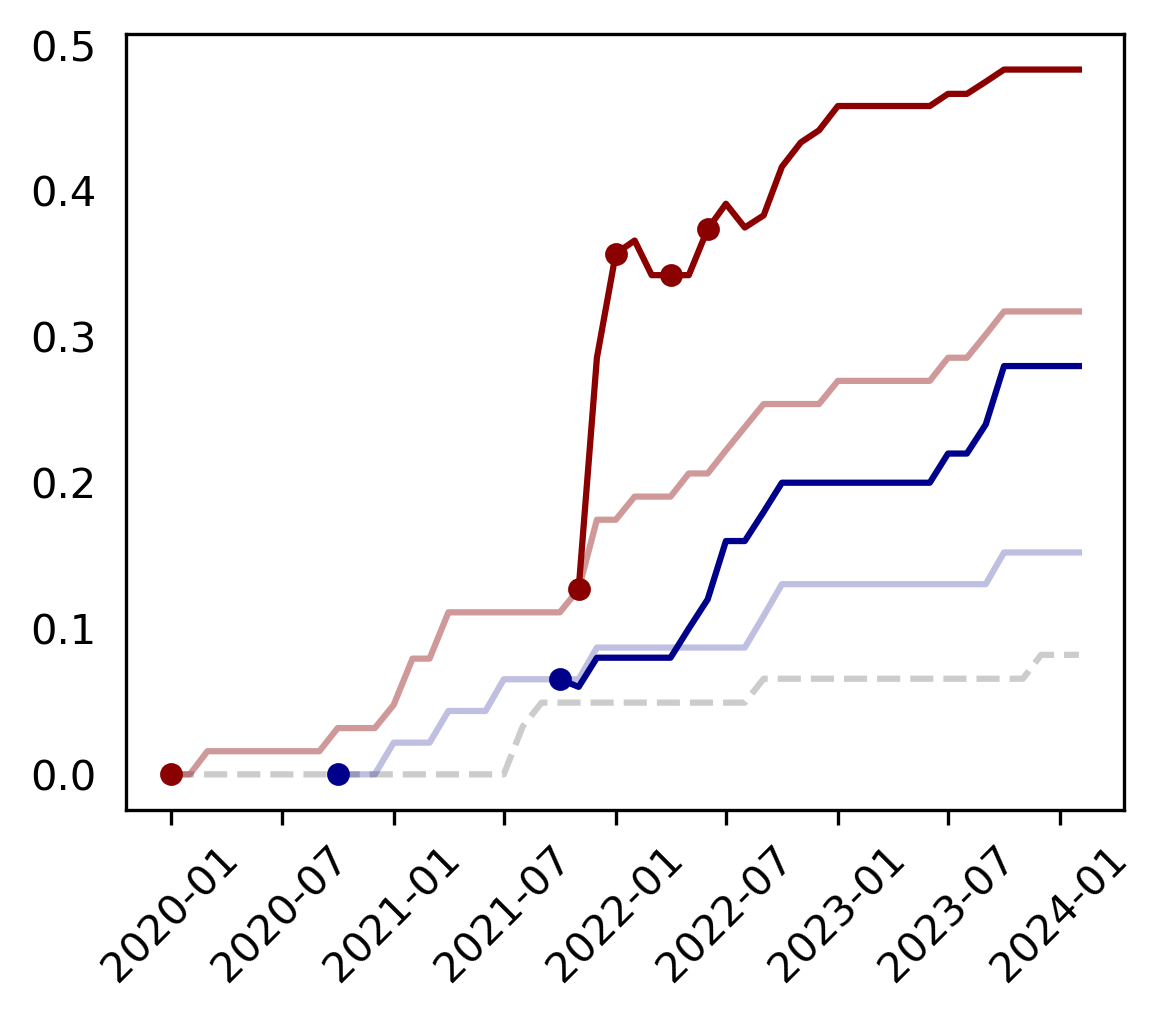

In [54]:
fig, ax = plt.subplots(1,1,figsize=(4,3.5))

ax.plot(dates[22:], f[22:], label='Updated', c="darkred")

ax.plot(dates[21:], b[21:], label='updated_dms', c="darkblue")
ax.plot(dates[9:], frac_seen['Greaney_dms'][9:], label='Early DMS', c="darkblue", alpha = 0.25)

ax.plot(dates, frac_seen['rbd_random'], label='Random', c="k", linestyle = '--', alpha = 0.2, zorder = -100)
ax.tick_params(left = False, right=False)

ax.plot(dates, frac_seen['B.1_pre2020'], label='Pre2020', c="darkred", alpha = 0.4)

plt.scatter(dms_pts['date'], dms_pts['frac'], c = 'darkblue', s = 20)
plt.scatter(modl_pts['dates'], modl_pts['frac'], c = 'darkred', s = 20)
ax.set_xlabel("")
ax.set_ylabel("")


ax.set_xlabel("")
ax.set_ylabel("")

#plt.xticks(ticks = dates[0::6], labels=["1/20","7/20","1/21","7/21","1/22","7/22"])
plt.xticks(rotation = 45)
plt.tight_layout()    
#plt.legend()
fig.savefig('../Figures/Fig1b_progression.svg')

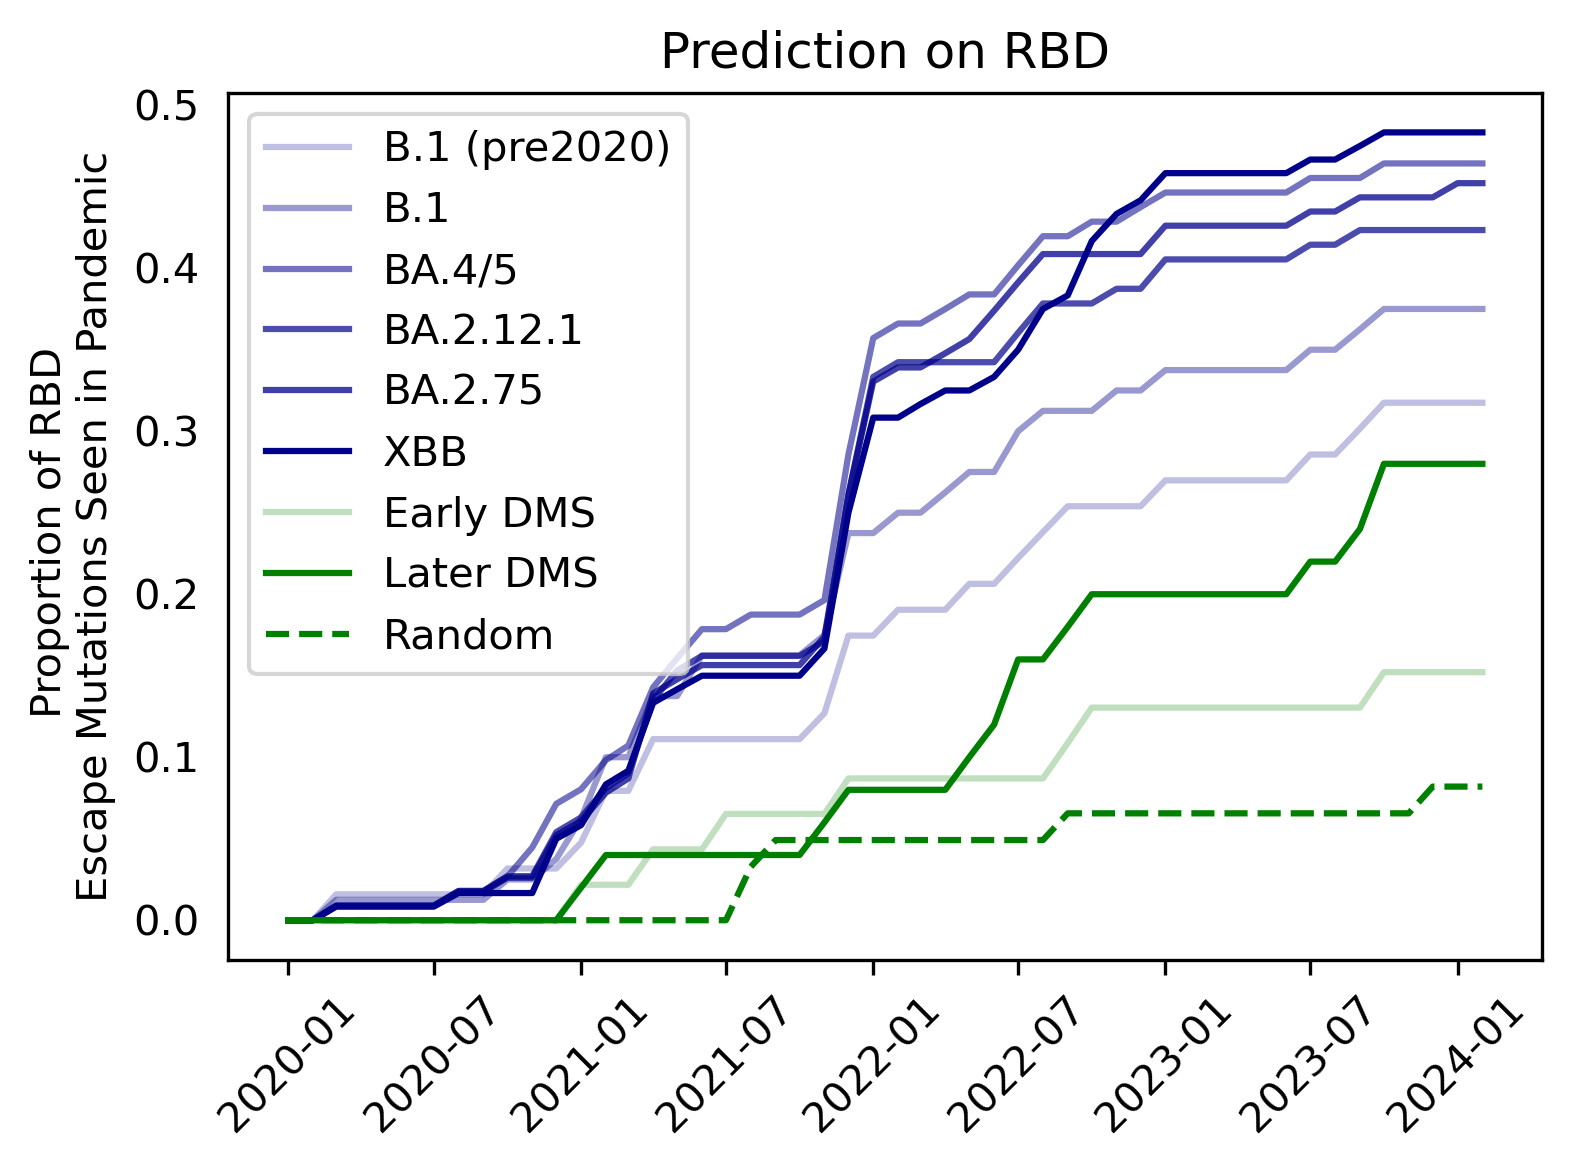

In [56]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

ax.plot(dates, frac_seen['B.1_pre2020'], label='B.1 (pre2020)', c="darkblue", alpha = 0.25)
ax.plot(dates, frac_seen['B.1'], label='B.1', c="darkblue", alpha = 0.4)
ax.plot(dates, frac_seen['BA.5'], label='BA.4/5', c="darkblue", alpha = 0.55)
ax.plot(dates, frac_seen['BA.2.12.1'], label='BA.2.12.1', c="darkblue", alpha = 0.7)
ax.plot(dates, frac_seen['BA.2.75'], label='BA.2.75', c="darkblue", alpha = 0.75)
ax.plot(dates, frac_seen['XBB'], label='XBB', c="darkblue")
ax.set_title("Prediction on RBD")


ax.plot(dates, frac_seen['Greaney_dms'], label='Early DMS', c="g", alpha = 0.25)
ax.plot(dates, frac_seen['all_dms'], label='Later DMS', c="g")
ax.plot(dates, frac_seen['rbd_random'], label='Random', c="g", linestyle = '--')
ax.tick_params(left = False, right=False)

ax.set_xlabel("")
ax.set_ylabel("")

plt.xticks(rotation = 45)
plt.tight_layout()    
plt.legend()
ax.set_ylabel('Proportion of RBD \nEscape Mutations Seen in Pandemic')
fig.savefig('../Figures/SuppFig1a.svg')

Text(0, 0.5, 'Proportion of Full Spike\nEscape Mutations Seen in Pandemic')

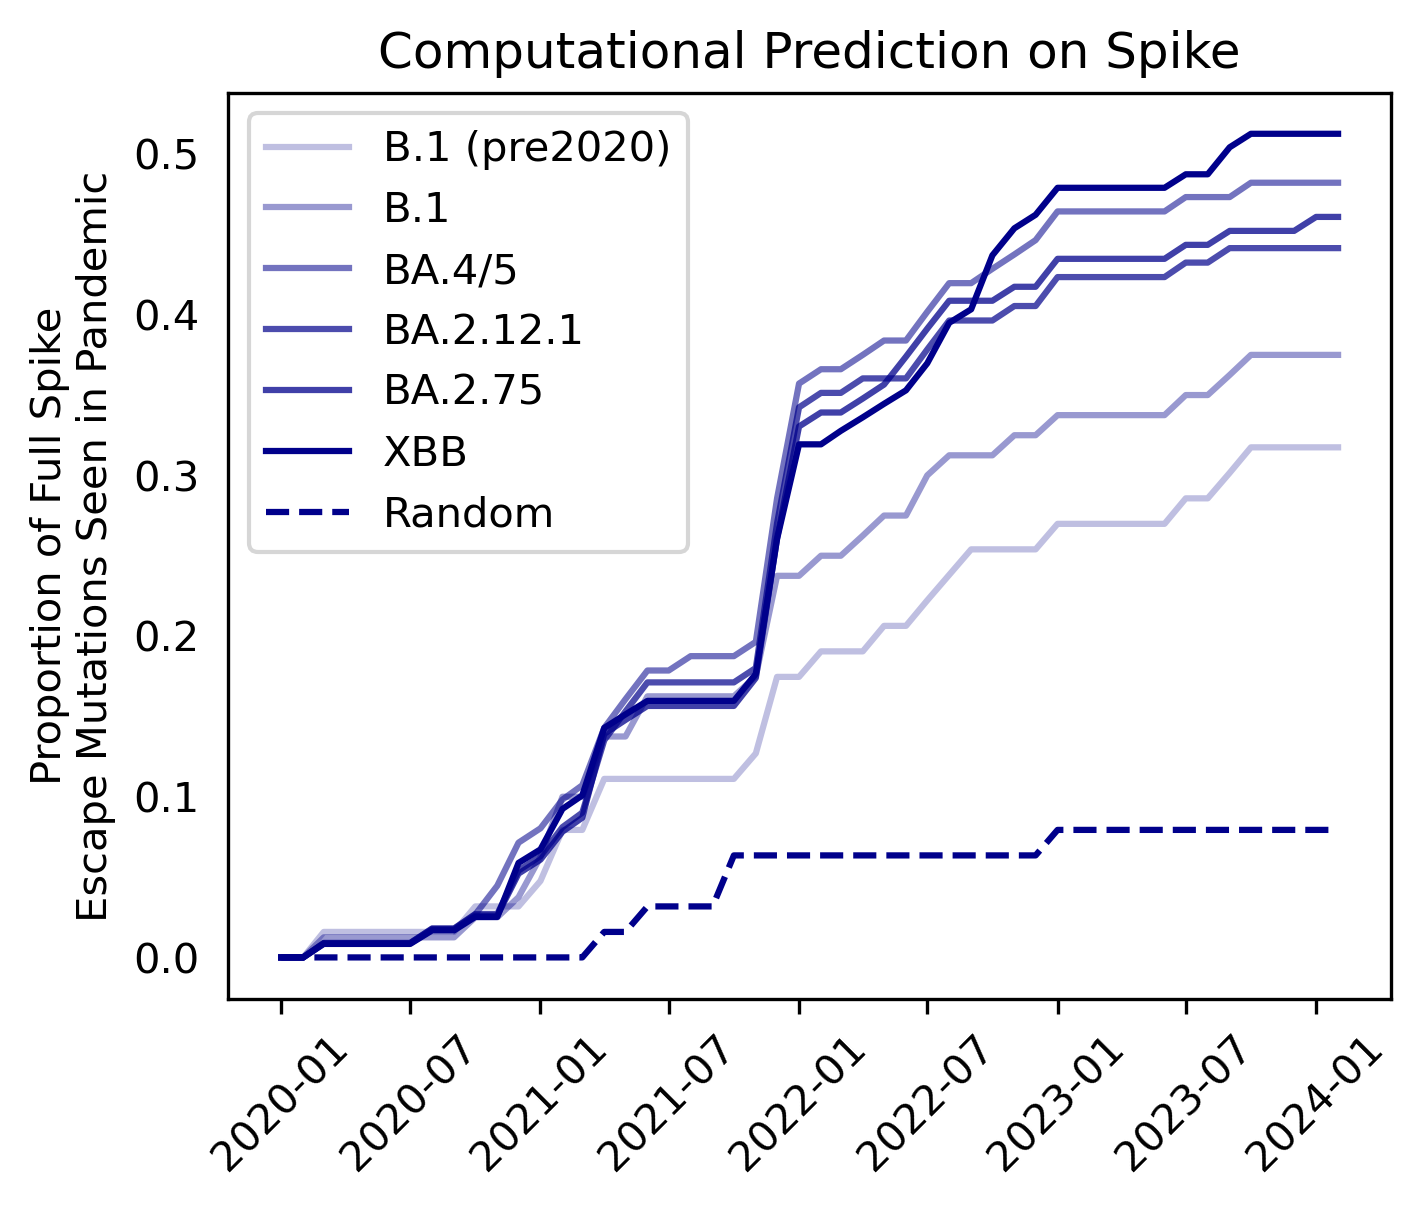

In [58]:
fig, ax = plt.subplots(1,1,figsize=(5,4), sharey = True, sharex = True)

ax.plot(dates, frac_seen['R1-1'], label='B.1 (pre2020)', c="darkblue", alpha = 0.25)
ax.plot(dates, frac_seen['R1-2'], label='B.1', c="darkblue", alpha = 0.4)
ax.plot(dates, frac_seen['R2-1'], label='BA.4/5', c="darkblue", alpha = 0.55)
ax.plot(dates, frac_seen['R2-2'], label='BA.2.12.1', c="darkblue", alpha = 0.7)
ax.plot(dates, frac_seen['R2-3'], label='BA.2.75', c="darkblue", alpha = 0.75)
ax.plot(dates, frac_seen['R2-4'], label='XBB', c="darkblue")
ax.plot(dates, frac_seen['spk_random'], label='Random', c="darkblue", linestyle = '--')
ax.set_title("Computational Prediction on Spike")


ax.tick_params(left = False, right=False)

ax.set_xlabel("")
ax.set_ylabel("")

#plt.xticks(ticks = dates[0::6], labels=["1/20","7/20","1/21","7/21","1/22","7/22"])
ax.legend()    
ax.tick_params(axis='x', labelrotation=45)

ax.set_ylabel('Proportion of Full Spike\nEscape Mutations Seen in Pandemic')